## Importing Libraries

In [6]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
# import re77
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

## Downloading datasets

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ransakaravihara/aerial-imagery-semantic-segmentation-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\kumar\.cache\kagglehub\datasets\ransakaravihara\aerial-imagery-semantic-segmentation-dataset\versions\1


## Defining the Data Loading Function

This function `LoadData` is responsible for loading aerial images and their corresponding binary segmentation masks. The processed data is appended into a dictionary called `framObjTrain` containing:

- `'img'`: List of resized aerial images.
- `'mask'`: List of binary masks (single-channel images).

### Function Parameters:
- `frameObj`: Dictionary to store loaded data (images and masks).
- `imgPath`: Directory containing satellite images.
- `maskPath`: Directory containing corresponding segmentation masks.
- `shape`: Target resolution (width × height) for resizing all images and masks.


In [ ]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

## Defining Conv2D Block

This function defines a basic building block for the UNet architecture. It performs two convolutional operations (optionally followed by batch normalization), each with ReLU activation.

### Parameters:
- `inputTensor`: Input feature map.
- `numFilters`: Number of filters in the convolutional layers.
- `kernelSize`: Size of the convolutional kernel.
- `doBatchNorm`: Whether to apply batch normalization after convolutions.


## Building the UNet Model

This function constructs a complete UNet model for image segmentation.

- **Encoder**: Repeated `Conv2dBlock`s followed by max-pooling and dropout.
- **Bottleneck**: Deepest layer with the highest number of filters.
- **Decoder**: Transposed convolutions for upsampling, skip connections from encoder, followed by `Conv2dBlock`s.

### Parameters:
- `inputImage`: Input layer for the model.
- `numFilters`: Base number of filters (doubles after each pooling layer).
- `droupouts`: Dropout rate applied after pooling or concatenation.
- `doBatchNorm`: Toggle for batch normalization usage.

### Returns:
- A compiled UNet model.


In [9]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


## Instantiating and Compiling the UNet Model

This block defines the input shape and creates the UNet model using the `GiveMeUnet()` function. It then compiles the model with the following setup:

- **Input shape**: `128x128` RGB images (3 channels).
- **Dropout**: Set to `0.07` to prevent overfitting.
- **Optimizer**: `Adam`, a commonly used adaptive optimizer for deep learning.
- **Loss Function**: `binary_crossentropy`, suitable for binary segmentation tasks.
- **Metrics**: `accuracy`, to track how well the predicted mask matches the ground truth.

The model is now ready to be trained on aerial images for segmentation.


In [10]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/deepglobe-road-extraction-dataset/train', 
                        maskPath = '/kaggle/input/deepglobe-road-extraction-dataset/train'
                         , shape = 256)

## Visualizing Sample Data

This block visualizes the first few images and their corresponding segmentation masks from the dataset to confirm successful loading.


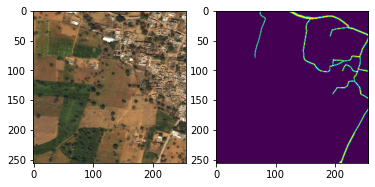

In [7]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

## Training the UNet Model

This block trains the UNet model using the preprocessed aerial images and masks. Training runs for 40 epochs with `accuracy` and `loss` logged for each epoch.


In [8]:
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 40, verbose = 1)

Epoch 1/40
195/195 [==============================] - 40s 206ms/step - loss: 0.2878 - accuracy: 0.9354
Epoch 2/40
195/195 [==============================] - 39s 202ms/step - loss: 0.1553 - accuracy: 0.9533
Epoch 3/40
195/195 [==============================] - 39s 202ms/step - loss: 0.1217 - accuracy: 0.9550
Epoch 4/40
195/195 [==============================] - 39s 202ms/step - loss: 0.1048 - accuracy: 0.9595
Epoch 5/40
195/195 [==============================] - 39s 202ms/step - loss: 0.0952 - accuracy: 0.9620
Epoch 6/40
195/195 [==============================] - 39s 202ms/step - loss: 0.0876 - accuracy: 0.9641
Epoch 7/40
195/195 [==============================] - 39s 202ms/step - loss: 0.0833 - accuracy: 0.9653
Epoch 8/40
195/195 [==============================] - 39s 202ms/step - loss: 0.0797 - accuracy: 0.9663
Epoch 9/40
195/195 [==============================] - 39s 202ms/step - loss: 0.0774 - accuracy: 0.9670
Epoch 10/40
195/195 [==============================] - 39s 202ms/step - l

## Plotting Training Loss and Accuracy

This block visualizes the training progress over 40 epochs. It plots:
- **Training Loss** (`binary_crossentropy`): Measures how well the predicted segmentation mask matches the ground truth.
- **Training Accuracy**: Percentage of correctly classified pixels.

This visualization helps monitor convergence, overfitting, or underfitting during training.


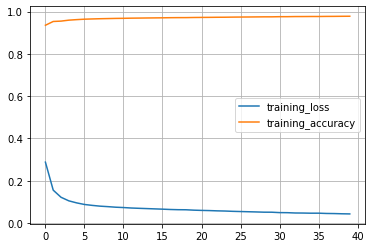

In [9]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [10]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')
    
  

In [11]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)

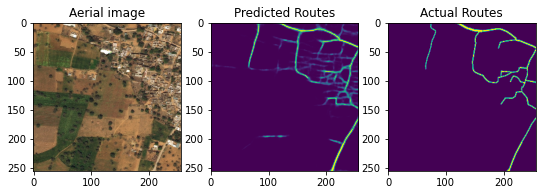

In [12]:
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

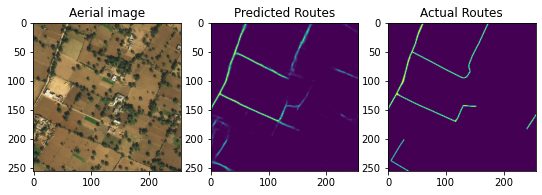

In [13]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

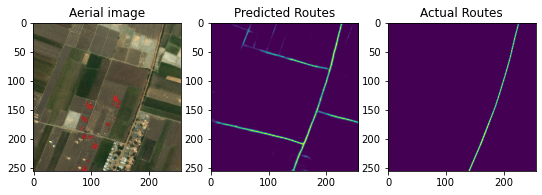

In [14]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

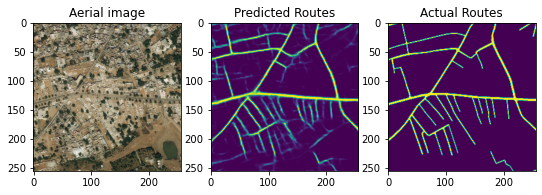

In [15]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

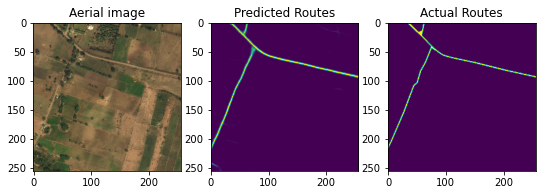

In [16]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

In [17]:
unet.save('RouteGenerator.h5')